In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
# Troque pelo nome do seu arquivo CSV
df = pd.read_csv('../data/DENGBR25.csv')

# Verifique se carregou
print(df.head())

nunique = df.nunique(dropna=False).sort_values()

/tmp/ipykernel_20013/3221433809.py:2: DtypeWarning: Columns (22,44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/DENGBR25.csv')


   TP_NOT ID_AGRAVO  DT_NOTIFIC  SEM_NOT  NU_ANO  SG_UF_NOT  ID_MUNICIP  \
0       2       A90  2025-01-06   202502    2025         12      120020   
1       2       A90  2025-01-13   202503    2025         12      120020   
2       2       A90  2025-02-19   202508    2025         12      120020   
3       2       A90  2025-03-17   202512    2025         12      120020   
4       2       A90  2025-04-06   202515    2025         12      120020   

   ID_REGIONA  ID_UNIDADE  DT_SIN_PRI  ...  EVIDENCIA  PLAQ_MENOR  CON_FHD  \
0      1941.0   2000202.0  2025-01-01  ...        NaN         NaN      NaN   
1      1941.0   2002914.0  2025-01-11  ...        NaN         NaN      NaN   
2      1941.0   2000202.0  2025-02-14  ...        NaN         NaN      NaN   
3      1941.0   5336171.0  2025-03-16  ...        NaN         NaN      NaN   
4      1941.0   5336171.0  2025-03-25  ...        NaN         NaN      NaN   

  COMPLICA  TP_SISTEMA  NDUPLIC_N   DT_DIGITA  CS_FLXRET  FLXRECEBI  MIGRADO_W  

In [3]:
df.describe()

,TP_NOT,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,ANO_NASC,NU_IDADE_N,...,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI,MIGRADO_W
count,1605624.0,1.605624e+06,1.605624e+06,1.605624e+06,1.605624e+06,1.557265e+06,1.605464e+06,1.605624e+06,1.601051e+06,1.605624e+06,...,0.0,0.0,0.0,0.0,0.0,1587307.0,4339.0,1.605624e+06,1.0,0.0
mean,2.0,2.025155e+05,2.024999e+03,3.607638e+01,3.632703e+05,1.458755e+03,4.088451e+06,2.025149e+05,1.988136e+03,4.025077e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.034652e-01,2.0,NaN
std,0.0,9.558214e+00,3.678015e-02,7.121180e+00,7.084692e+04,3.807356e+02,2.612719e+06,9.487917e+00,2.007280e+01,1.308771e+02,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.597545e-01,NaN,NaN
min,2.0,2.025010e+05,2.024000e+03,1.100000e+01,1.100010e+05,1.331000e+03,1.700000e+01,2.025010e+05,1.900000e+03,6.000000e+00,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
25%,2.0,2.025090e+05,2.025000e+03,3.500000e+01,3.504000e+05,1.342000e+03,2.087219e+06,2.025080e+05,1.974000e+03,4.020000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
50%,2.0,2.025140e+05,2.025000e+03,3.500000e+01,3.534400e+05,1.354000e+03,2.746298e+06,2.025130e+05,1.990000e+03,4.035000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
75%,2.0,2.025190e+05,2.025000e+03,3.500000e+01,3.555400e+05,1.465000e+03,6.595421e+06,2.025190e+05,2.004000e+03,4.050000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.000000e+00,2.0,NaN
max,2.0,2.025470e+05,2.025000e+03,5.300000e+01,5.300100e+05,6.256000e+03,9.999949e+06,2.025470e+05,2.981000e+03,4.407000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.000000e+00,2.0,NaN


In [4]:
#Drop das colunas 100% NaN
cols_100_nan = [
    "DOENCA_TRA","MANI_HEMOR","EPISTAXE","GENGIVO","METRO","PETEQUIAS",
    "HEMATURA","SANGRAM","LACO_N","PLASMATICO","EVIDENCIA","PLAQ_MENOR",
    "CON_FHD","COMPLICA","MIGRADO_W"
]
df = df.drop(columns=cols_100_nan, errors="ignore")

df.describe()

,TP_NOT,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,ANO_NASC,NU_IDADE_N,...,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI
count,1605624.0,1.605624e+06,1.605624e+06,1.605624e+06,1.605624e+06,1.557265e+06,1.605464e+06,1.605624e+06,1.601051e+06,1.605624e+06,...,2989.000000,2986.000000,2983.000000,2985.000000,2990.000000,2984.000000,1587307.0,4339.0,1.605624e+06,1.0
mean,2.0,2.025155e+05,2.024999e+03,3.607638e+01,3.632703e+05,1.458755e+03,4.088451e+06,2.025149e+05,1.988136e+03,4.025077e+03,...,1.939779,1.972539,1.939323,1.979899,1.698328,1.848525,2.0,1.0,3.034652e-01,2.0
std,0.0,9.558214e+00,3.678015e-02,7.121180e+00,7.084692e+04,3.807356e+02,2.612719e+06,9.487917e+00,2.007280e+01,1.308771e+02,...,0.237935,0.163451,0.238777,0.140368,0.459061,0.358571,0.0,0.0,4.597545e-01,NaN
min,2.0,2.025010e+05,2.024000e+03,1.100000e+01,1.100010e+05,1.331000e+03,1.700000e+01,2.025010e+05,1.900000e+03,6.000000e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0,1.0,0.000000e+00,2.0
25%,2.0,2.025090e+05,2.025000e+03,3.500000e+01,3.504000e+05,1.342000e+03,2.087219e+06,2.025080e+05,1.974000e+03,4.020000e+03,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.0,1.0,0.000000e+00,2.0
50%,2.0,2.025140e+05,2.025000e+03,3.500000e+01,3.534400e+05,1.354000e+03,2.746298e+06,2.025130e+05,1.990000e+03,4.035000e+03,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,1.0,0.000000e+00,2.0
75%,2.0,2.025190e+05,2.025000e+03,3.500000e+01,3.555400e+05,1.465000e+03,6.595421e+06,2.025190e+05,2.004000e+03,4.050000e+03,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,1.0,1.000000e+00,2.0
max,2.0,2.025470e+05,2.025000e+03,5.300000e+01,5.300100e+05,6.256000e+03,9.999949e+06,2.025470e+05,2.981000e+03,4.407000e+03,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,1.0,1.000000e+00,2.0


In [5]:
df['CS_GESTANT'].unique()

array([ 5.,  6.,  2.,  9.,  4.,  3.,  1., nan])

In [6]:
#Drop das colunas que não possuem valores uteis para a analise de casos graves de dengue 
colunas_sem_valor_analise = [
    "TP_NOT", "ID_AGRAVO", "DT_NOTIFIC", "SEM_NOT", "NU_ANO",
    "SG_UF_NOT", "ID_MUNICIP", "ID_REGIONA", "ID_UNIDADE", "SEM_PRI","ANO_NASC", "CS_RACA", "CS_ESCOL_N",
    "SG_UF", "ID_MN_RESI", "ID_RG_RESI", "ID_PAIS","DT_INVEST", "ID_OCUPA_N","DOENCA_TRA", "MANI_HEMOR", 
    "EPISTAXE", "GENGIVO", "METRO", "PETEQUIAS", "HEMATURA", "SANGRAM", "LACO_N", "PLASMATICO",
    "EVIDENCIA", "PLAQ_MENOR", "CON_FHD", "COMPLICA", "MIGRADO_W",
    "DT_CHIK_S1", "DT_CHIK_S2", "DT_PRNT", "DT_SORO", "DT_NS1", "DT_VIRAL", 
    "DT_PCR", "DT_INTERNA", "DT_OBITO", "DT_ENCERRA", "DT_ALRM", "DT_GRAV", 
    "DT_DIGITA", "GRAV_PULSO", "GRAV_CONV", "GRAV_ENCH", "GRAV_INSUF", "GRAV_TAQUI",
    "GRAV_EXTRE", "GRAV_HIPOT", "GRAV_HEMAT", "GRAV_MELEN",
    "GRAV_METRO", "GRAV_SANG", "GRAV_AST", "GRAV_MIOC",
    "GRAV_CONSC", "GRAV_ORGAO", "UF", "MUNICIPIO", "COUFINF", "COPAISINF",
    "COMUNINF", "CLASSI_FIN", "NDUPLIC_N", "FLXRECEBI", "CRITERIO", "EVOLUCAO"
]

df = df.drop(columns=colunas_sem_valor_analise, errors="ignore")

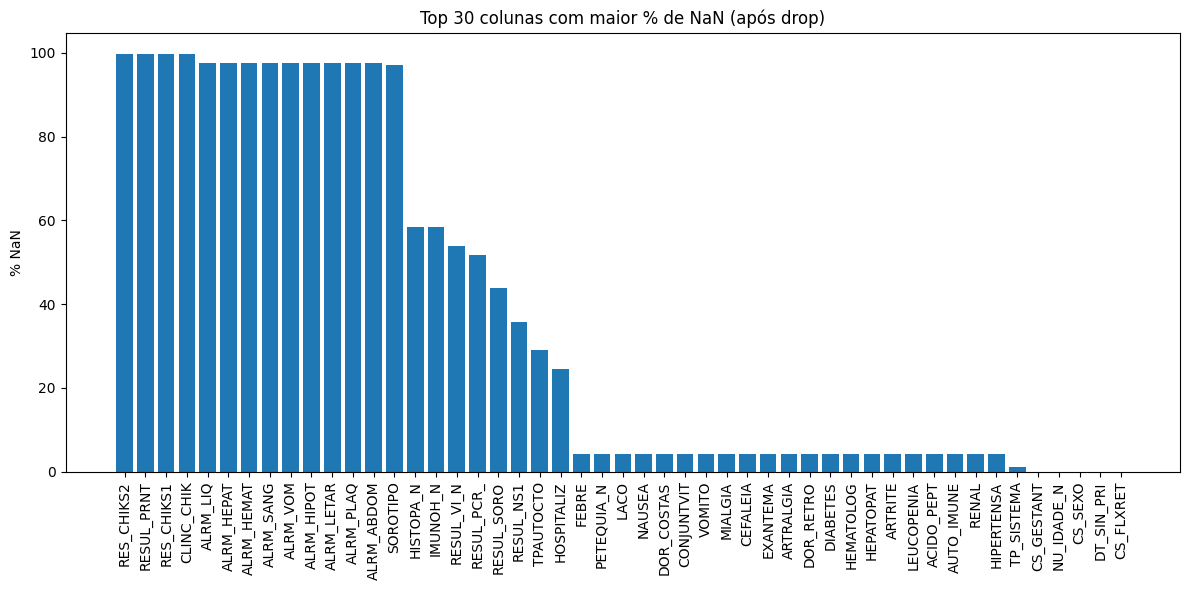

In [7]:
nan_pct = (df.isna().mean() * 100).sort_values(ascending=False)

top = nan_pct.head(60)

plt.figure(figsize=(12, 6))
plt.bar(top.index.astype(str), top.values)
plt.xticks(rotation=90)
plt.ylabel('% NaN')
plt.title('Top 30 colunas com maior % de NaN (após drop)')
plt.tight_layout()
plt.show()

In [8]:
# O data_frame_subs será o data frame com valores substituidos, criando uma nova categoria
data_frame_subs = df.copy()

# O data_frame_convert será o data frame com valores convertidos, convertendo os nan em valores que ja existam
data_frame_convert = df.copy()

### 4.1 Definição de Sintomas e Comorbidades

Definição das colunas que representam sintomas clínicos, sinais de alarme e comorbidades. Estas variáveis binárias terão seus valores ausentes tratados de acordo com as duas estratégias definidas.

In [9]:
# Trantando os Nan como o valor 2(não), afim de ajustar os dados para o modelo
colunas_nan_nao = [
    "RENAL", "HEPATOPAT", "HIPERTENSA", "FEBRE", "MIALGIA", "CEFALEIA",
    "EXANTEMA", "VOMITO", "NAUSEA", "DOR_COSTAS", "CONJUNTVIT",
    "ARTRITE", "ARTRALGIA", "PETEQUIA_N", "LEUCOPENIA", "LACO",
    "DOR_RETRO", "DIABETES", "HEMATOLOG", "ACIDO_PEPT", "AUTO_IMUNE",
    "ALRM_HIPOT", "ALRM_PLAQ", "ALRM_VOM", "ALRM_SANG", "ALRM_HEMAT",
    "ALRM_ABDOM", "ALRM_LETAR", "ALRM_HEPAT", "ALRM_LIQ",
]

In [10]:
# Converter os valores Nan, tratando eles como se fossem 3(não informado)
data_frame_subs[colunas_nan_nao] = (
    data_frame_subs[colunas_nan_nao].fillna(3)
)

In [11]:
# Converter os valores Nan, tratando eles como se fossem 2(não)
data_frame_convert[colunas_nan_nao] = (
    data_frame_convert[colunas_nan_nao].fillna(2)
)

In [12]:
# Colunas com quatro opções possiveis de valor
colunas_quatro_valores_possiveis = [
    "RES_CHIKS1", "RES_CHIKS2", "RESUL_PRNT", "RESUL_SORO", "RESUL_NS1", 
    "RESUL_VI_N", "RESUL_PCR_", "HISTOPA_N", "IMUNOH_N"
]

In [13]:
# Converter os valores Nan, tratando eles como se fossem 4(não realizado)
data_frame_subs[colunas_quatro_valores_possiveis] = (
    data_frame_subs[colunas_quatro_valores_possiveis].fillna(4)
)

# Converter os valores Nan, tratando eles como se fossem 5(não informado)
data_frame_convert[colunas_quatro_valores_possiveis] = (
    data_frame_convert[colunas_quatro_valores_possiveis].fillna(5)
)

In [14]:
# 1. Se CS_SEXO é 'M' e CS_GESTANT é NaN, atribui 6
data_frame_convert.loc[(data_frame_convert['CS_SEXO'] == 'M') & (data_frame_convert['CS_GESTANT'].isna()), 'CS_GESTANT'] = 6
data_frame_subs.loc[(data_frame_subs['CS_SEXO'] == 'M') & (data_frame_subs['CS_GESTANT'].isna()), 'CS_GESTANT'] = 6

# 2. Se CS_SEXO é 'F' e CS_GESTANT é NaN, atribui 5
data_frame_convert.loc[(data_frame_convert['CS_SEXO'] == 'F') & (data_frame_convert['CS_GESTANT'].isna()), 'CS_GESTANT'] = 5
data_frame_subs.loc[(data_frame_subs['CS_SEXO'] == 'F') & (data_frame_subs['CS_GESTANT'].isna()), 'CS_GESTANT'] = 9

In [15]:
# Converter os valores Nan, em "SOROTIPO", tratando eles como se fossem 5(não informado)
data_frame_subs["SOROTIPO"] = (
    data_frame_subs["SOROTIPO"].fillna(5)
)
data_frame_convert["SOROTIPO"] = (
    data_frame_convert["SOROTIPO"].fillna(5)
)

In [16]:
# Converter os valores Nan, em "HOSPITALIZ", tratando eles como se 
# fossem 3(Não informado)
data_frame_subs["HOSPITALIZ"] = (
    data_frame_subs["HOSPITALIZ"].fillna(3)
)

# Converter os valores Nan, em "HOSPITALIZ", tratando eles como se 
# fossem 9(IGNORADO)
data_frame_convert["HOSPITALIZ"] = (
    data_frame_convert["HOSPITALIZ"].fillna(9)
)

In [17]:
# Converter os valores Nan, em "TPAUTOCTO", tratando eles como se 
# fossem 4(Não informado)
data_frame_subs["TPAUTOCTO"] = (
    data_frame_subs["TPAUTOCTO"].fillna(4)
)

# Converter os valores Nan, em "TPAUTOCTO", tratando eles como se 
# fossem 3(Indeterminado)
data_frame_convert["TPAUTOCTO"] = (
    data_frame_convert["TPAUTOCTO"].fillna(3)
)

In [18]:
# Converter os valores Nan, em "CLINC_CHIK", tratando eles como se 
# fossem 3(Não informado)
data_frame_subs["CLINC_CHIK"] = (
    data_frame_subs["CLINC_CHIK"].fillna(3)
)

data_frame_convert["CLINC_CHIK"] = (
    data_frame_convert["CLINC_CHIK"].fillna(3)
)

In [19]:
# Converter os valores Nan, em "TP_SISTEMA", tratando eles como se 
# fossem 3(Não informado)
data_frame_subs["TP_SISTEMA"] = (
    data_frame_subs["TP_SISTEMA"].fillna(3)
)

data_frame_convert["TP_SISTEMA"] = (
    data_frame_convert["TP_SISTEMA"].fillna(3)
)

In [20]:
colunas_com_nan = data_frame_convert.columns[
    data_frame_convert.isna().any()
].tolist()

colunas_com_nan

[]

In [21]:
# Data frame com os valores substituidos, com novos valores
data_frame_subs.head()

,DT_SIN_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,...,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,TP_SISTEMA,CS_FLXRET
0,2025-01-01,4059,F,5.0,2.0,1.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0
1,2025-01-11,4036,M,6.0,1.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0
2,2025-02-14,4030,F,5.0,1.0,1.0,1.0,1.0,1.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0
3,2025-03-16,4028,M,6.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,1
4,2025-03-25,4028,M,6.0,1.0,2.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,1


In [22]:
# Data frame com os valores convertidos, para algum valor possivel
data_frame_convert.head()

,DT_SIN_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,...,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,TP_SISTEMA,CS_FLXRET
0,2025-01-01,4059,F,5.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
1,2025-01-11,4036,M,6.0,1.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0
2,2025-02-14,4030,F,5.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
3,2025-03-16,4028,M,6.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
4,2025-03-25,4028,M,6.0,1.0,2.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1


## Análise gráfica de fatores associados a hospitalização


1. Criação de variáveis binárias para facilitar a análise. A variável de hospitalização será convertida para formato binário onde 1 indica hospitalização e 0 indica não hospitalização.

In [23]:
def sinan_bin(x):
    if x == 1:
        return 1
    if x == 2:
        return 0
    return None  # ignora 9, NaN, etc
df_visualizer = df.copy()

df_visualizer["hosp_bin"] = df_visualizer["HOSPITALIZ"].apply(sinan_bin)


### 1.1 Visualização Geral de Hospitalizações

Grafico para mostrar proporção de casos hospitalizados vs total de casos notificados.

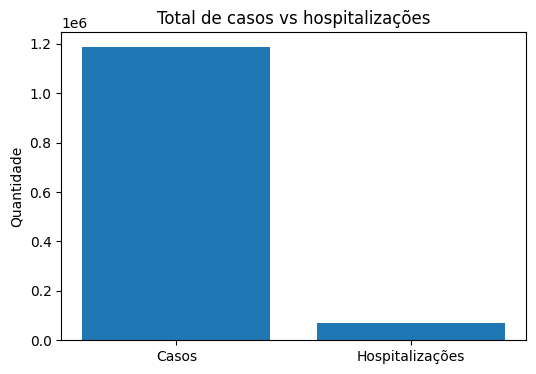

In [24]:

total_ocurrences = df_visualizer["hosp_bin"].notna().sum()
total_hospitalized = df_visualizer["hosp_bin"].sum()

labels = ["Casos", "Hospitalizações"]
values = [total_ocurrences, total_hospitalized]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Quantidade")
plt.title("Total de casos vs hospitalizações")
plt.show()

### 1.2 Impacto de Sintomas e Comorbidades

Análise do impacto cada sintoma e comorbidade na taxa de hospitalização. O objetivo é identificar quais variáveis clínicas estão associadas com casos graves que necessitam hospitalização.

In [25]:
symptoms = [
    "FEBRE",
    "MIALGIA",
    "CEFALEIA",
    "EXANTEMA",
    "VOMITO",
    "NAUSEA",
    "DOR_COSTAS",
    "CONJUNTVIT",
    "ARTRITE",
    "ARTRALGIA",
    "PETEQUIA_N",     
    "LEUCOPENIA",   
    "LACO",          
    "DOR_RETRO"      
]

deseases = [
    "DIABETES",
    "HEMATOLOG",
    "HEPATOPAT",
    "RENAL",
    "HIPERTENSA",
    "ACIDO_PEPT",
    "AUTO_IMUNE"
]

Conversão das variáveis clínicas para formato binário, onde 1 representa presença do sintoma/comorbidade e 0 representa ausência.

In [26]:
def sinan_bin(s):
    x = pd.to_numeric(s, errors="coerce")
    return x.map({1: 1.0, 2: 0.0})



variables = symptoms + deseases
X = df_visualizer[variables].apply(sinan_bin)


y = sinan_bin(df_visualizer["HOSPITALIZ"]).rename("hosp") 

Cálculo da diferença na taxa de hospitalização entre pacientes com e sem cada sintoma/comorbidade.

**Como interpretar**: Valores positivos indicam que a presença do sintoma/doença aumenta a probabilidade de hospitalização. A diferença é medida em **pontos percentuais (pp)**.

**Exemplo prático**: Se 5% dos pacientes sem diabetes são hospitalizados e 15% dos pacientes com diabetes são hospitalizados, a diferença é de +10 pontos percentuais. Isso significa que ter diabetes está associado a um aumento de 10 pontos percentuais na taxa de hospitalização.

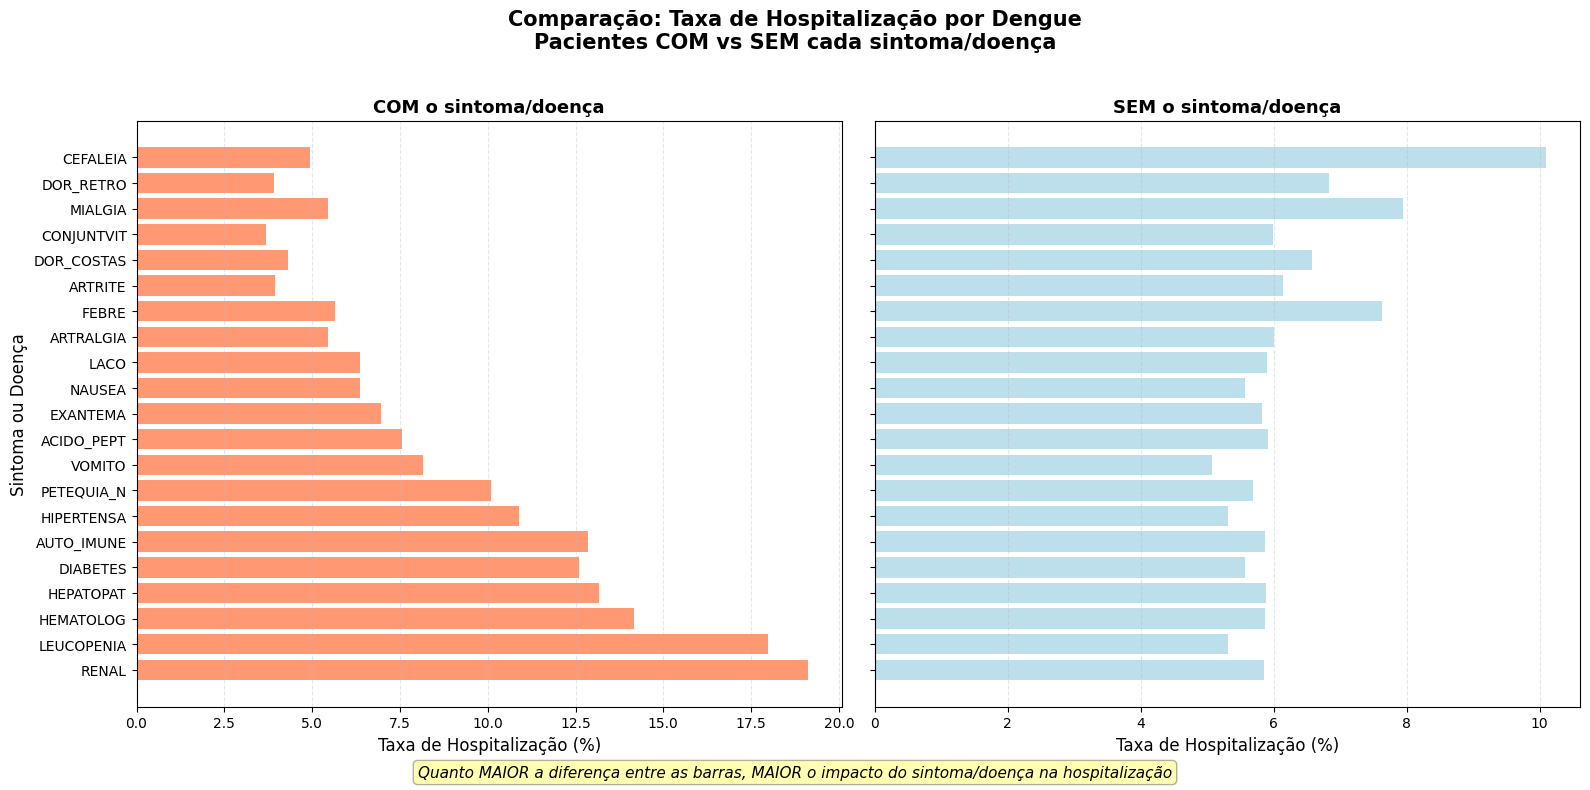

In [27]:
rates = []
for col in variables:
    tmp = pd.concat([X[col], y.rename("hosp")], axis=1).dropna()


    grp = tmp.groupby(col)["hosp"].mean()

    hosp_rate_no  = grp.get(0.0, np.nan)  
    hosp_rate_yes = grp.get(1.0, np.nan)  

    rates.append({
        "symptom": col,
        "hosp_rate_no": hosp_rate_no,
        "hosp_rate_yes": hosp_rate_yes,
        "delta_pp": (hosp_rate_yes - hosp_rate_no) * 100
    })

rates_df = pd.DataFrame(rates).sort_values("delta_pp", ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.barh(rates_df["symptom"], rates_df["hosp_rate_yes"] * 100, color='coral', alpha=0.8)
ax1.set_xlabel("Taxa de Hospitalização (%)", fontsize=12)
ax1.set_ylabel("Sintoma ou Doença", fontsize=12)
ax1.set_title("COM o sintoma/doença", fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

ax2.barh(rates_df["symptom"], rates_df["hosp_rate_no"] * 100, color='lightblue', alpha=0.8)
ax2.set_xlabel("Taxa de Hospitalização (%)", fontsize=12)
ax2.set_title("SEM o sintoma/doença", fontsize=13, fontweight='bold')
ax2.set_yticklabels([])  # Remove labels duplicados
ax2.grid(axis='x', alpha=0.3, linestyle='--')

fig.suptitle('Comparação: Taxa de Hospitalização por Dengue\nPacientes COM vs SEM cada sintoma/doença', 
             fontsize=15, fontweight='bold', y=0.98)

fig.text(0.5, 0.02, 
         'Quanto MAIOR a diferença entre as barras, MAIOR o impacto do sintoma/doença na hospitalização',
         ha='center', fontsize=11, style='italic',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### 5.3 Análise por Faixa Etária e Doença

Investigação da relação entre idade, presença de doença(diabetes) e risco de hospitalização.
 A idade é uma variável importante em dengue, especialmente quando combinada com comorbidades como diabetes.



Conversão da variável de idade do formato SINAN para anos. O campo NU_IDADE_N armazena idade codificada onde os primeiros dígitos indicam a unidade (horas, dias, meses ou anos).

/tmp/ipykernel_20013/1891669870.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_range", "DIABETES"])["hosp"]


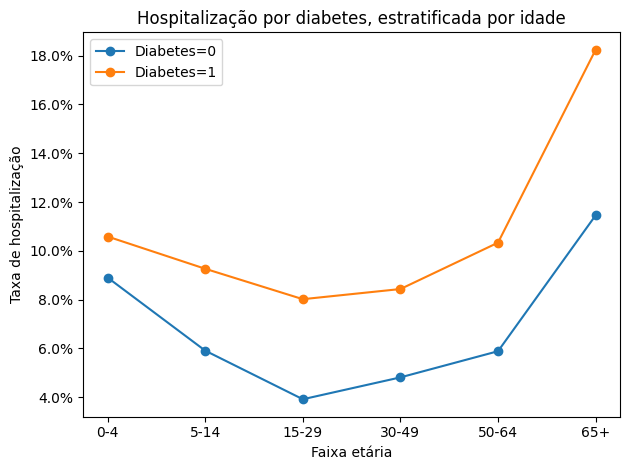

In [28]:
bins = [0, 5, 15, 30, 50, 65, 120]
labels = ["0-4","5-14","15-29","30-49","50-64","65+"]

def age_years(nu_age):
    if pd.isna(nu_age):
        return np.nan

    try:
        nu_age = int(nu_age)
    except:
        return np.nan

    unidade = nu_age // 1000
    valor   = nu_age % 1000

    if unidade == 1:      # horas
        return valor / (24 * 365)
    elif unidade == 2:    # dias
        return valor / 365
    elif unidade == 3:    # meses
        return valor / 12
    elif unidade == 4:    # anos
        return valor
    else:
        return np.nan
    
df_visualizer["age_years"] = df_visualizer["NU_IDADE_N"].apply(age_years)

df_visualizer["age_range"] = pd.cut(df_visualizer["age_years"], bins=bins, labels=labels)

tmp = pd.concat([
    X["DIABETES"],
    y,
    df_visualizer["age_range"]
], axis=1).dropna()

rate_age = (
    tmp
    .groupby(["age_range", "DIABETES"])["hosp"]
    .mean()
    .reset_index()
)
rate_age

for v in [0.0, 1.0]:
    sub = rate_age[rate_age["DIABETES"] == v]
    plt.plot(sub["age_range"], sub["hosp"], marker="o", label=f"Diabetes={int(v)}")

plt.ylabel("Taxa de hospitalização")
plt.xlabel("Faixa etária")
plt.title("Hospitalização por diabetes, estratificada por idade")

plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 5.4 Sazonalidade da Hospitalização

Análise temporal para identificar padrões sazonais na taxa de hospitalização.

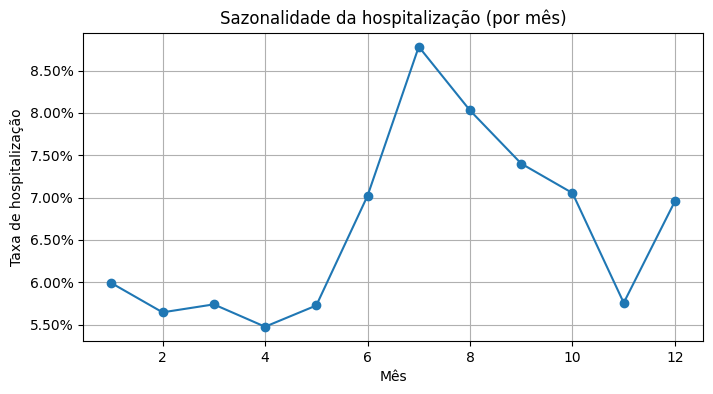

In [29]:
df["dt_sint"] = pd.to_datetime(df["DT_SIN_PRI"], errors="coerce")
df["mes"] = df["dt_sint"].dt.month

tmp = pd.concat([y, df["mes"]], axis=1).dropna()

rate_month = (
    tmp
    .groupby("mes")["hosp"]
    .mean()
)

plt.figure(figsize=(8,4))
rate_month.plot(marker="o")
plt.xlabel("Mês")
plt.ylabel("Taxa de hospitalização")
plt.title("Sazonalidade da hospitalização (por mês)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.show()

### 5.5 Fatores de Risco Específicos

Análise de grupos de risco específicos, incluindo gestantes e presença de sinais de alarme. Estes fatores são particularmente importantes para identificação precoce de casos graves.

x# sexo feminino

Comparação da taxa de hospitalização entre gestantes e não gestantes. A gravidez é um fator de risco conhecido para complicações de dengue.

              hosp
pregnant          
0.0       0.055758
1.0       0.136026


<Figure size 800x500 with 0 Axes>

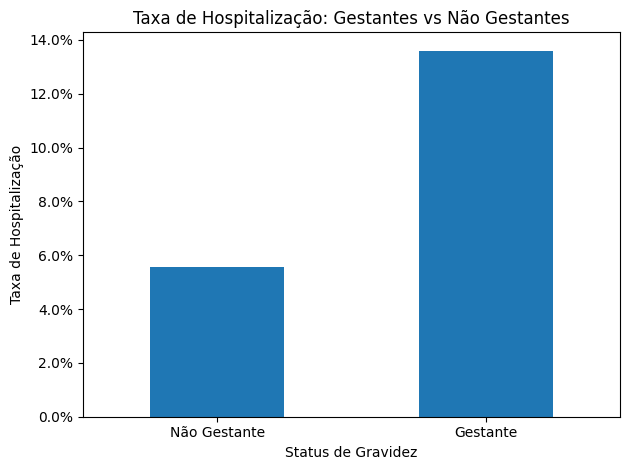

In [30]:

df["sex_female"] = (df["CS_SEXO"] == "F").astype("Int64")
df_f = df[df["CS_SEXO"].eq("F")].copy()

def gestante_bin(v):
    if v in [1, 2, 3, 4]:
        return 1.0   # gestante
    if v == 5:
        return 0.0   # não gestante
    return None      # ignora 6, 9, NaN

df["pregnant"] = df["CS_GESTANT"].apply(gestante_bin)


tmp = pd.concat([df["pregnant"], y.loc[df_f.index]], axis=1).dropna()

resultado_gestantes = tmp.groupby("pregnant").mean()
print(resultado_gestantes)

# Gráfico de barras para gestantes
plt.figure(figsize=(8, 5))
resultado_gestantes.plot(kind='bar', legend=False)
plt.xlabel("Status de Gravidez")
plt.ylabel("Taxa de Hospitalização")
plt.title("Taxa de Hospitalização: Gestantes vs Não Gestantes")
plt.xticks([0, 1], ['Não Gestante', 'Gestante'], rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 5.7 Distribuição de Casos por Faixa Etária

Visualização da quantidade de casos em cada faixa etária para identificar os grupos mais afetados.

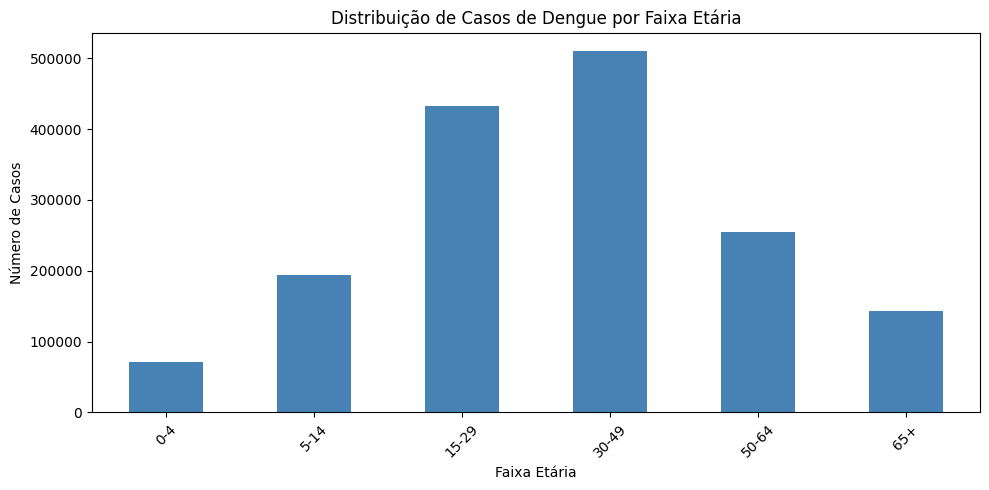

In [31]:
# Distribuição por faixa etária
faixa_counts = df_visualizer["age_range"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
faixa_counts.plot(kind='bar', color='steelblue')
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Casos")
plt.title("Distribuição de Casos de Dengue por Faixa Etária")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.8 Correlação entre Sintomas

Mapa de calor mostrando a correlação entre diferentes sintomas. Valores próximos a 1 indicam que os sintomas tendem a aparecer juntos.

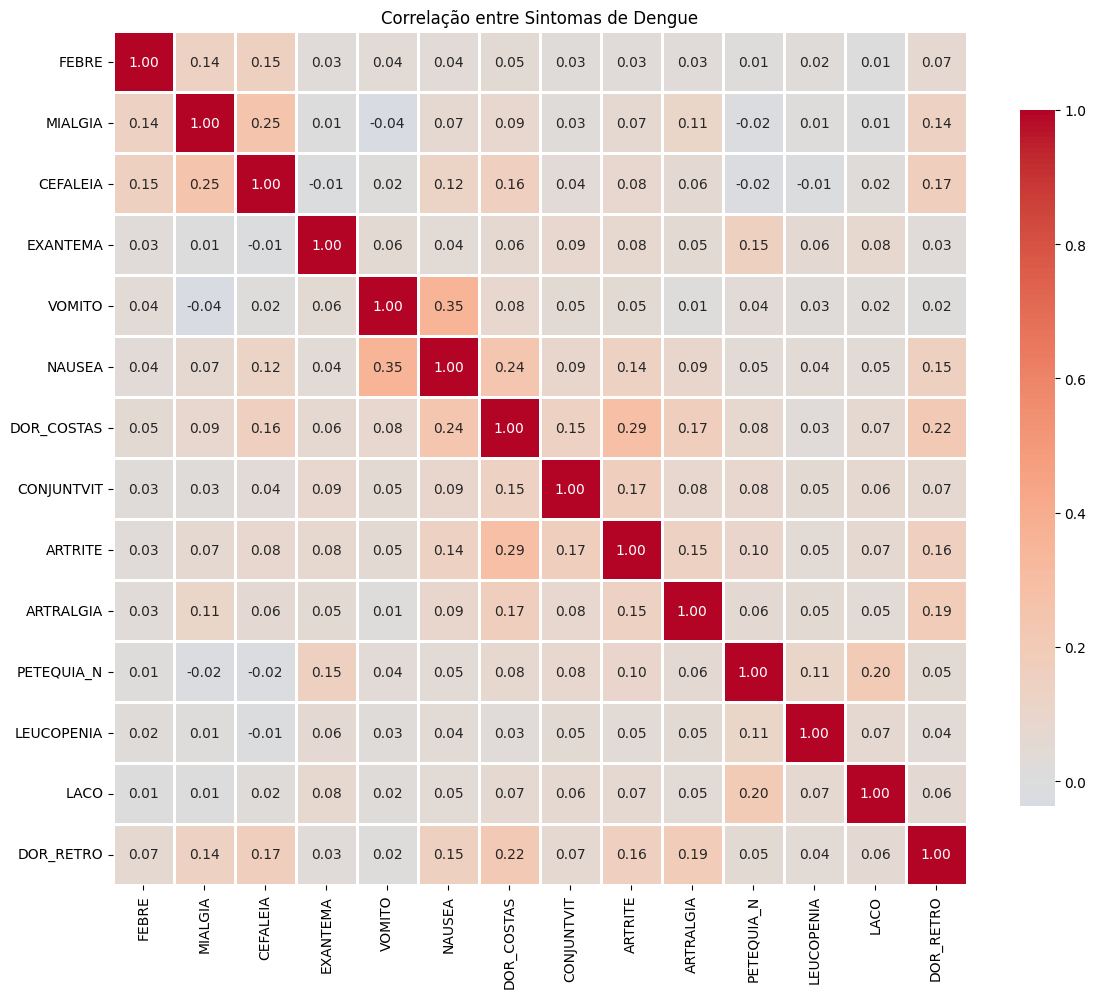

In [32]:
# Heatmap de correlação entre sintomas
import seaborn as sns

correlacao = X[symptoms].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlação entre Sintomas de Dengue")
plt.tight_layout()
plt.show()

In [33]:
data_frame_convert.head()

,DT_SIN_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,...,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,TP_SISTEMA,CS_FLXRET
0,2025-01-01,4059,F,5.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
1,2025-01-11,4036,M,6.0,1.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0
2,2025-02-14,4030,F,5.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
3,2025-03-16,4028,M,6.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
4,2025-03-25,4028,M,6.0,1.0,2.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1


In [34]:
data_frame_subs.head()

,DT_SIN_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,...,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,TP_SISTEMA,CS_FLXRET
0,2025-01-01,4059,F,5.0,2.0,1.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0
1,2025-01-11,4036,M,6.0,1.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0
2,2025-02-14,4030,F,5.0,1.0,1.0,1.0,1.0,1.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0
3,2025-03-16,4028,M,6.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,1
4,2025-03-25,4028,M,6.0,1.0,2.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,1


In [36]:
data_frame_convert = data_frame_convert[data_frame_convert['CS_SEXO'] != 'I']
data_frame_subs = data_frame_subs[data_frame_subs['CS_SEXO'] != 'I']

In [37]:
# Identifica quais colunas são do tipo texto
colunas_texto = data_frame_convert.select_dtypes(include=['object']).columns.tolist()

print(f"Colunas que precisam de conversão: {colunas_texto}")

Colunas que precisam de conversão: ['DT_SIN_PRI', 'CS_SEXO']


In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data_frame_convert['CS_SEXO'] = le.fit_transform(data_frame_convert['CS_SEXO'])
data_frame_subs['CS_SEXO'] = le.fit_transform(data_frame_subs['CS_SEXO'])

0          0
1          1
2          0
3          1
4          1
          ..
1605619    0
1605620    0
1605621    0
1605622    0
1605623    1
Name: CS_SEXO, Length: 1604423, dtype: int64


In [41]:
# Garante que a coluna está no formato de data
data_frame_convert['DT_SIN_PRI'] = pd.to_datetime(data_frame_convert['DT_SIN_PRI'])

# Extrai os componentes numéricos
data_frame_convert['ANO_SIN'] = data_frame_convert['DT_SIN_PRI'].dt.year
data_frame_convert['MES_SIN'] = data_frame_convert['DT_SIN_PRI'].dt.month
data_frame_convert['DIA_SIN'] = data_frame_convert['DT_SIN_PRI'].dt.day
data_frame_convert['DIA_SEMANA_SIN'] = data_frame_convert['DT_SIN_PRI'].dt.dayofweek # 0=Segunda, 6=Domingo

# Agora que temos os números, removemos a coluna original de data
data_frame_convert = data_frame_convert.drop('DT_SIN_PRI', axis=1)

In [ ]:
# Garante que a coluna está no formato de data
data_frame_subs['DT_SIN_PRI'] = pd.to_datetime(data_frame_subs['DT_SIN_PRI'])

# Extrai os componentes numéricos
data_frame_subs['ANO_SIN'] = data_frame_subs['DT_SIN_PRI'].dt.year
data_frame_subs['MES_SIN'] = data_frame_subs['DT_SIN_PRI'].dt.month
data_frame_subs['DIA_SIN'] = data_frame_subs['DT_SIN_PRI'].dt.day
data_frame_subs['DIA_SEMANA_SIN'] = data_frame_subs['DT_SIN_PRI'].dt.dayofweek # 0=Segunda, 6=Domingo

# Agora que temos os números, removemos a coluna original de data
data_frame_subs = data_frame_subs.drop('DT_SIN_PRI', axis=1)

In [44]:
# Se der algo como 95% para 0 e 5% para 1, está desbalanceado.
print(data_frame_convert['HOSPITALIZ'].value_counts(normalize=True))

HOSPITALIZ
2.0    0.695653
9.0    0.260597
1.0    0.043750
Name: proportion, dtype: float64


In [45]:
print(data_frame_subs['HOSPITALIZ'].value_counts(normalize=True))

HOSPITALIZ
2.0    0.695653
3.0    0.244255
1.0    0.043750
9.0    0.016342
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Função para preparar os dataframes para os modelos, no caso, normalizando e balanceado os dois dataframes.
def preparar_dados(df, target_col):
    # 1. Separar X e y
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # 2. Divisão Treino e Teste (80/20)
    # O stratify é vital aqui para manter a proporção da hospitalização
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 3. Normalização (Fit apenas no treino para evitar Leakage)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. Balanceamento (SMOTE) apenas no treino
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    
    return X_train_res, X_test_scaled, y_train_res, y_test

In [ ]:
# Dados tratados para o uso no modelos
# Preparando o primeiro (com valor 9)
X_train_9, X_test_9, y_train_9, y_test_9 = preparar_dados(data_frame_convert, 'HOSPITALIZ')

# Preparando o segundo (com valor 3)
X_train_3, X_test_3, y_train_3, y_test_3 = preparar_dados(data_frame_subs, 'HOSPITALIZ')